# Машинне навчання
# Лабораторна робота №2
# Вишотравка Діана СА-33
## Варіант 4

In [160]:
from typing import Tuple, Dict, Any

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn.preprocessing
from scipy.stats import uniform
from sklearn.preprocessing import StandardScaler, PowerTransformer, TargetEncoder, MinMaxScaler, RobustScaler, FunctionTransformer, OneHotEncoder, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn_pandas import DataFrameMapper, gen_features, NumericalTransformer
from math import log1p, log
from sklearn.feature_selection import chi2, f_regression

import warnings
warnings.filterwarnings('ignore')
sns.set_palette("tab20b")

In [161]:
class TransformerList:
    def __init__(self, transformers):
        self.transformers = transformers

    def fit_transform(self, data, y=None):
        for transformer in self.transformers:
            data = transformer.fit_transform(data)
        return data

    def transform(self, data):
        for transformer in self.transformers:
            data = transformer.transform(data)
        return data
    def inverse_transform(self, data):
        for transformer in self.transformers[::-1]:
            data = transformer.inverse_transform(data)
        return data

In [162]:
class StandartLog:
    def __init__(self, *args, **kwargs):
        self.scaler = StandardScaler(*args, **kwargs)
        
    def fit_transform(self, data):
        return self.scaler.fit_transform(np.vectorize(lambda x: log1p(1/x))(data))
    
    def transform(self, data):
        return self.scaler.transform(np.vectorize(lambda x: log1p(1/x))(data))

In [163]:
def regression_report(y_true: pd.Series | np.ndarray, y_pred: pd.Series | np.ndarray, x_train: pd.Series | np.ndarray) -> dict[str, float ]:
        return ({
            'MSE': mean_squared_error(y_true, y_pred),
            'RMSE': root_mean_squared_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'R^2': r2_score(y_true, y_pred),
            'Adjusted R^2': 1 - (1 - r2_score(y_true, y_pred)) * (x_train.shape[0] - 1) / (x_train.shape[0] - x_train.shape[1] - 1)
        })


def report(x_train, x_test, y_train_raw, y_test_raw, model, target_transformer=None):

    if target_transformer is None:
        return pd.DataFrame(
            [
                regression_report(y_train_raw, np.reshape(model.predict(x_train), (-1, 1)), x_train),
                regression_report(y_test_raw, np.reshape(model.predict(x_test), (-1, 1)), x_train),
            ],
            index=['Train set', 'Test set']
        ).T, np.reshape(model.predict(x_test), (-1, 1))
    else:
        return pd.DataFrame(
            [
                regression_report(y_train_raw,
                                  target_transformer.inverse_transform(np.reshape(model.predict(x_train), (-1, 1))),x_train),
                regression_report(y_test_raw,
                                  target_transformer.inverse_transform(np.reshape(model.predict(x_test), (-1, 1))), x_train),
            ],
            index=['Train set', 'Test set']
        ).T, target_transformer.inverse_transform(np.reshape(model.predict(x_test), (-1, 1)))

In [164]:
df = pd.read_csv('forestfires.csv')
df.drop_duplicates(inplace=True)

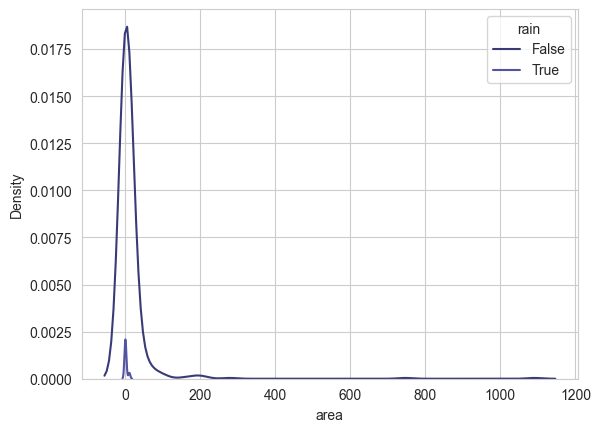

In [165]:
df['rain'] = df['rain'].apply(lambda x: True if x != 0 else False)
sns.kdeplot(df, x = 'area', hue= 'rain')
plt.show()

In [166]:
numerical = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH','wind', 'area']
categorical = ['X', 'Y', 'month', 'day', 'rain']

# Splitting

In [167]:
x_train, x_test, y_train, y_st_test = train_test_split(df.loc[:, [i != 'area' for i in df.columns.to_list()]], df.loc[:, ['area']], test_size=0.2, random_state=113131313)

In [168]:
x_train.shape

(410, 12)

# Preprocessing

## Target value

In [169]:
column_transformer = TransformerList([FunctionTransformer(np.log1p, np.expm1), MinMaxScaler()])
y_st_train_changed = column_transformer.fit_transform(y_train)

## Others

In [170]:
categorical_mapping = gen_features(
    columns=[['month'], ['rain'], ['day']],
    classes=[TargetEncoder]
)
numerical_mapping = gen_features(
    columns=[[i] for i in ['DMC', 'DC', 'ISI', 'temp','wind']],
    classes=[StandardScaler]
)

In [171]:
mapper = DataFrameMapper(
    categorical_mapping + numerical_mapping + [(['FFMC'], StandartLog()), (['RH'], [FunctionTransformer(np.log1p, np.expm1), StandardScaler()])],
    default=None,
    df_out= True
)

In [172]:
x_st_train_changed, x_st_test_changed = mapper.fit_transform(x_train, y_st_train_changed), mapper.transform(x_test)

# Standart Linear regression model

In [173]:
linmod_stand = LinearRegression()
linmod_stand.fit(
    x_st_train_changed,
    y_st_train_changed
)

LinearRegression()

## Feature importance

In [174]:
coef_stand = pd.DataFrame({
    'Feature': [f'{i}' for i in df.columns[:-1] ] + ['θ0'],
    'Coefficient': linmod_stand.coef_.tolist()[0] + linmod_stand.intercept_.tolist()
})
coef_stand

,Feature,Coefficient
0,X,-0.054054
1,Y,-0.207786
2,month,-0.766141
3,day,0.009565
4,FFMC,0.006003
5,DMC,-0.012332
6,DC,0.010922
7,ISI,0.022674
8,temp,-0.005345
9,RH,-0.013157


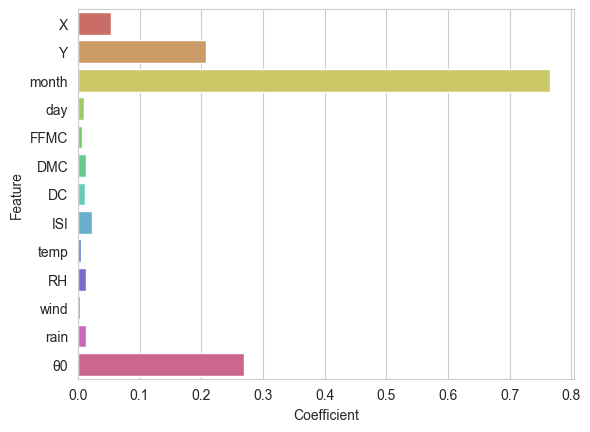

In [175]:
sns.barplot(x = abs(coef_stand['Coefficient']), y = coef_stand['Feature'], orient='h', palette='hls')
plt.show()

In [176]:
info_standart, y_st_pred_test = report(x_st_train_changed, x_st_test_changed, y_train, y_st_test, linmod_stand, column_transformer)
info_standart

,Train set,Test set
MSE,5152.765135,230.694847
RMSE,71.782763,15.188642
MAE,14.760889,6.098014
R^2,-0.025454,-0.047347
Adjusted R^2,-0.056450,-0.079004


## Residual Analysis

In [177]:
def analyze_residuals(y_true: pd.Series, y_pred: pd.Series | np.ndarray):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(15, 4.5))
    residuals = y_true.reset_index(drop=True) - y_pred
    residuals.name = 'residuals'
    
    sns.histplot(x=residuals['area'], alpha=0.8, kde=True, element='step', ax=axs[0])

    sns.residplot(x = y_true, y = residuals, color="g", ax=axs[1])
  
    sns.scatterplot(x=np.array(y_true).flatten(), y=np.array(y_pred).flatten(), ax=axs[2])
    
    axs[0].set_title('Residual distribution')
    axs[1].set(title='Residual plot', xlabel='y_true', ylabel='residuals')
    axs[2].set(title='y_true vs y_pred', xlabel='y_true', ylabel='y_pred')
    
    plt.show()
    

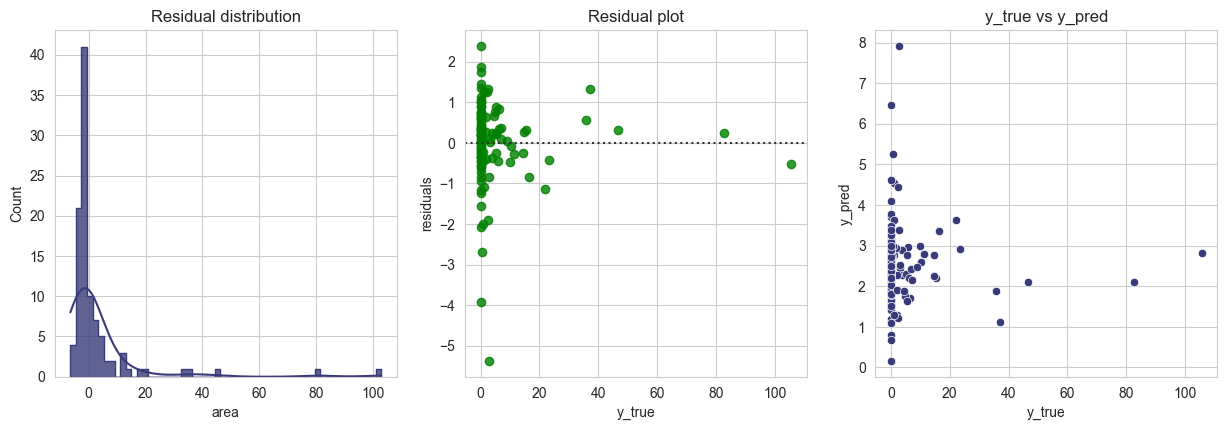

In [178]:
analyze_residuals(y_st_test, y_st_pred_test)

## 2 TRY

In [179]:
df_nozero = df.loc[(df['area']  > 1) & (df['area'] <= 200)]
df_nozero

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
148,2,2,aug,tue,94.8,108.3,647.1,17.0,17.4,43,6.7,False,1.07
149,8,6,sep,thu,93.7,80.9,685.2,17.9,23.7,25,4.5,False,1.12
150,6,5,jun,fri,92.5,56.4,433.3,7.1,23.2,39,5.4,False,1.19
151,9,9,jul,sun,90.1,68.6,355.2,7.2,24.8,29,2.2,False,1.36
152,3,4,jul,sat,90.1,51.2,424.1,6.2,24.6,43,1.8,False,1.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...
505,1,2,aug,thu,91.0,163.2,744.4,10.1,26.7,35,1.8,False,5.80
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,True,2.17
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,False,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,False,54.29


In [180]:
zero_small, zero = train_test_split(df.loc[(df['area'] < 1)], test_size=0.9, random_state=113131313)
zero_small

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,False,0.00
91,8,6,mar,fri,91.7,35.8,80.8,7.8,17.4,24,5.4,False,0.00
134,3,5,mar,tue,88.1,25.7,67.6,3.8,14.9,38,2.7,False,0.00
492,1,3,aug,fri,95.9,158.0,633.6,11.3,32.4,27,2.2,False,0.00
305,1,4,sep,sun,89.6,84.1,714.3,5.7,19.0,52,2.2,False,0.00
455,3,4,jul,mon,94.6,160.0,567.2,16.7,17.9,48,2.7,False,0.00
304,6,5,may,sat,85.1,28.0,113.8,3.5,11.3,94,4.9,False,0.00
36,6,3,oct,tue,90.6,35.4,669.1,6.7,21.7,24,4.5,False,0.00
51,4,3,aug,sun,90.2,99.6,631.2,6.3,21.5,34,2.2,False,0.00
295,7,5,jun,sun,93.1,180.4,430.8,11.0,22.2,48,1.3,False,0.00


<Axes: xlabel='area', ylabel='Density'>

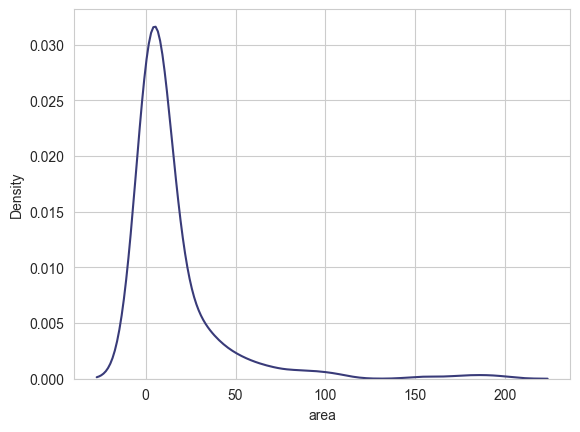

In [181]:
df_nozero = pd.concat([df_nozero, zero_small], ignore_index=True)
sns.kdeplot(df_nozero, x = 'area')

<Axes: >

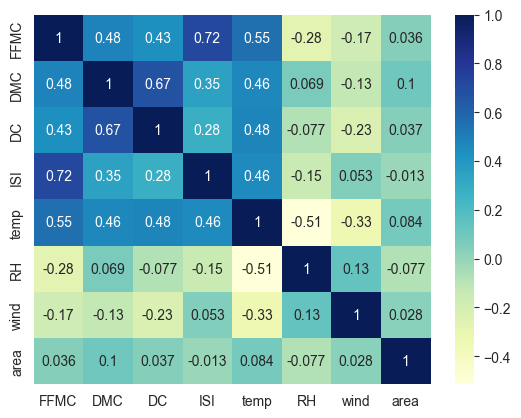

In [182]:
sns.heatmap(df_nozero.loc[:, numerical].corr(), cmap = 'YlGnBu', annot = True)

# Splitting

In [183]:
x_train, x_test, y_train, y_sec_test = train_test_split(df_nozero.loc[:, [i != 'area' for i in df.columns.to_list()]], df_nozero.loc[:, ['area']], test_size=0.2, random_state=113131313)

# Preprocesing

In [184]:
column_transformer = TransformerList([FunctionTransformer(np.log1p, np.expm1), MinMaxScaler()])
y_sec_train_changed = column_transformer.fit_transform(y_train)

In [185]:
categorical_mapping = gen_features(
    columns=[['month'], ['rain'], ['day']],
    classes=[TargetEncoder]
)
numerical_mapping = gen_features(
    columns=[[i] for i in ['DMC', 'DC', 'ISI', 'temp','wind']],
    classes=[StandardScaler]
)

In [186]:
mapper = DataFrameMapper(
    categorical_mapping + numerical_mapping + [(['FFMC'], StandartLog()), (['RH'], [FunctionTransformer(np.log1p, np.expm1), StandardScaler()])],
    default=None,
    df_out= True

)

In [187]:
x_sec_train_changed, x_sec_test_changed = mapper.fit_transform(x_train, y_sec_train_changed), mapper.transform(x_test)

## Model

In [188]:
linmod_second = LinearRegression()
linmod_second.fit(
    x_sec_train_changed,
    y_sec_train_changed
)

LinearRegression()

In [189]:
coef_second = pd.DataFrame({
    'Feature': [f'{i}' for i in df_nozero.columns[:-1] ] + ['θ0'],
    'Coefficient': linmod_second.coef_.tolist()[0] + linmod_second.intercept_.tolist()
})
coef_second

,Feature,Coefficient
0,X,-0.944325
1,Y,-4.321667
2,month,-0.000042
3,day,0.036652
4,FFMC,0.004734
5,DMC,-0.006050
6,DC,-0.007889
7,ISI,0.039622
8,temp,0.016131
9,RH,-0.014275


In [190]:
info_second, y_sec_pred_test = report(x_sec_train_changed, x_sec_test_changed, y_train, y_sec_test, linmod_second, column_transformer)
info_second

,Train set,Test set
MSE,930.232590,275.766829
RMSE,30.499715,16.606229
MAE,13.969686,9.665412
R^2,-0.047065,-0.109354
Adjusted R^2,-0.110523,-0.176588


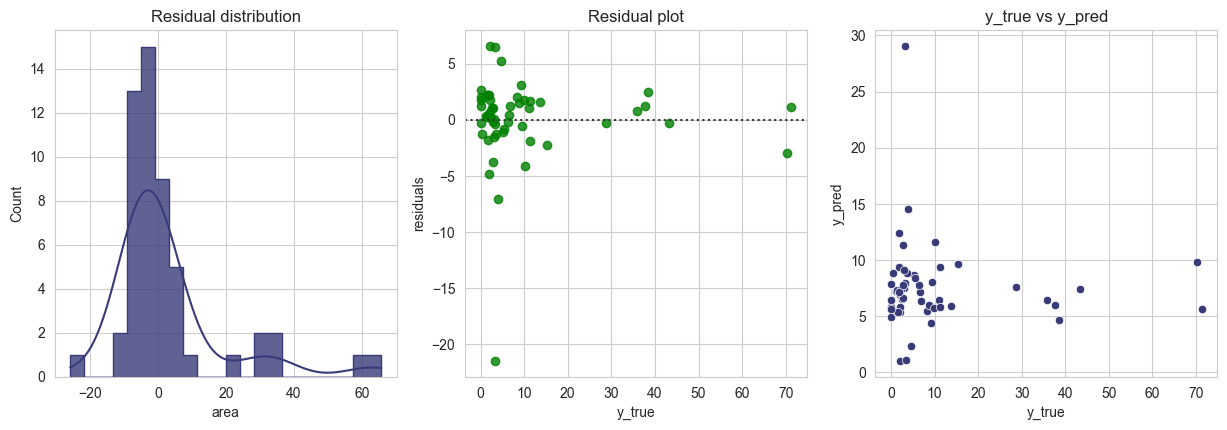

In [191]:
analyze_residuals(y_sec_test, y_sec_pred_test)

# Manually selected 3 features

In [192]:
manual_df = df_nozero.loc[:, ['RH', 'temp', 'month', 'area']]

# Splitting

In [193]:
x_train, x_test, y_train, y_man_test = train_test_split(manual_df.loc[:, [i != 'area' for i in manual_df.columns.to_list()]], manual_df.loc[:, ['area']], test_size=0.2, random_state=113131313)

# Preprocesing

In [194]:
column_transformer = TransformerList([FunctionTransformer(np.log1p, np.expm1), MinMaxScaler()])
y_man_train_changed = column_transformer.fit_transform(y_train)

In [195]:
numerical_mapping = gen_features(
    columns=[[i] for i in ['DMC', 'temp']],
    classes=[StandardScaler]
)

In [196]:
mapper = DataFrameMapper(
    [(['month'], sklearn.preprocessing.TargetEncoder()),(['RH'], [FunctionTransformer(np.log1p, np.expm1), StandardScaler()]), (['temp'], sklearn.preprocessing.StandardScaler())],
    default=None,
    df_out= True
)

In [197]:
x_man_train_changed, x_man_test_changed = mapper.fit_transform(x_train, y_man_train_changed), mapper.transform(x_test)

# Model

In [198]:
linmod_manual = LinearRegression()
linmod_manual.fit(
    x_man_train_changed,
    y_man_train_changed
)

LinearRegression()

In [199]:
info_manual, y_man_pred_test = report(x_man_train_changed, x_man_test_changed, y_train, y_man_test, linmod_manual, column_transformer)
info_manual

,Train set,Test set
MSE,984.352363,258.661506
RMSE,31.374390,16.082957
MAE,14.169030,8.815164
R^2,-0.107981,-0.040543
Adjusted R^2,-0.124039,-0.055623


## Residual Analysis

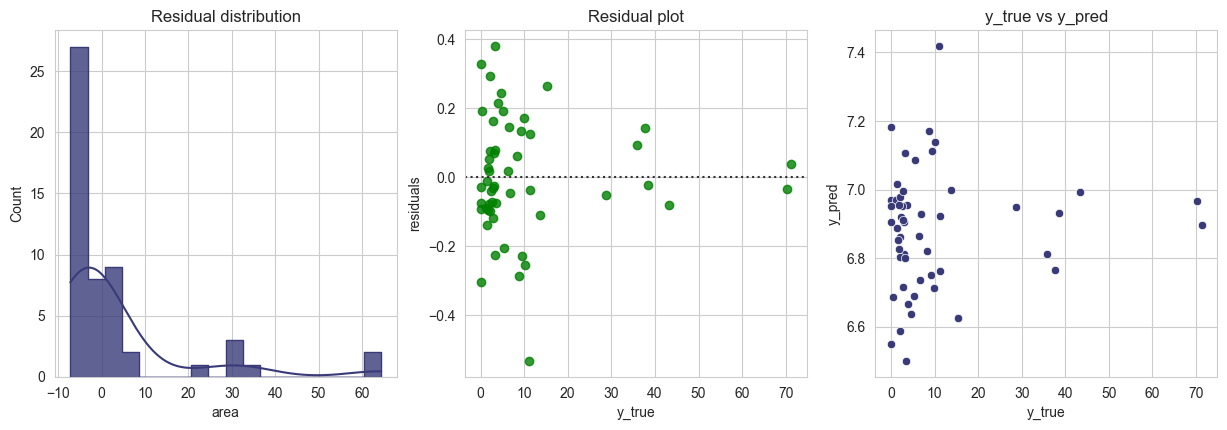

In [200]:
analyze_residuals(y_man_test, y_man_pred_test)

# SelectKBest

In [201]:
features = df.loc[:, [i != 'area' for i in df.columns.to_list()]]
target = df.loc[:, ['area']]

## Spliing

In [202]:
x_train, x_test, y_train, y_kbest_test = train_test_split(df.loc[:, [i != 'area' for i in df.columns.to_list()]], df.loc[:, ['area']], test_size=0.2, random_state=113131313)

## Preprocesing

In [203]:
column_transformer = TransformerList([FunctionTransformer(np.log1p, np.expm1), MinMaxScaler()])
y_kbest_train_changed = column_transformer.fit_transform(y_train)

In [204]:
categorical_mapping = gen_features(
    columns=[['month'], ['rain'], ['day']],
    classes=[TargetEncoder]
)
numerical_mapping = gen_features(
    columns=[[i] for i in ['DMC', 'DC', 'ISI', 'temp','wind']],
    classes=[StandardScaler]
)

In [205]:
mapper = DataFrameMapper(
    categorical_mapping + numerical_mapping + [(['FFMC'], StandartLog()), (['RH'], [FunctionTransformer(np.log1p, np.expm1), StandardScaler()])],
    default=None,
    df_out= True
)

In [206]:
x_kbest_train_changed, x_kbest_test_changed = mapper.fit_transform(x_train, y_kbest_train_changed), mapper.transform(x_test)

In [207]:
select = SelectKBest(score_func=f_regression, k=3)
x_kbest = select.fit_transform(x_kbest_train_changed, y_kbest_train_changed)
x_kbest

array([[ 0.17698709, -1.67452911,  5.        ],
       [ 0.16055549,  2.02316499,  6.        ],
       [ 0.142908  , -0.95706607,  3.        ],
       ...,
       [ 0.15922585,  0.53304946,  6.        ],
       [ 0.12461912, -0.18441358,  5.        ],
       [ 0.21309034,  0.53304946,  5.        ]])

In [208]:
filter = select.get_support()
features = np.array(x_kbest_train_changed.columns)
selected_features = features[filter]
selected_features

array(['day', 'wind', 'Y'], dtype=object)

## Model

In [209]:
linmod_kbest = LinearRegression()
linmod_kbest.fit(x_kbest_train_changed[selected_features], y_kbest_train_changed)

LinearRegression()

In [210]:
info_kbest, y_kbest_pred_test = report(x_kbest_train_changed[selected_features], x_kbest_test_changed[selected_features], y_train, y_kbest_test, linmod_kbest, column_transformer)
info_kbest

,Train set,Test set
MSE,5170.239547,231.235257
RMSE,71.904378,15.206422
MAE,14.791836,6.043447
R^2,-0.028932,-0.049800
Adjusted R^2,-0.036535,-0.057557


## Residual Analysis

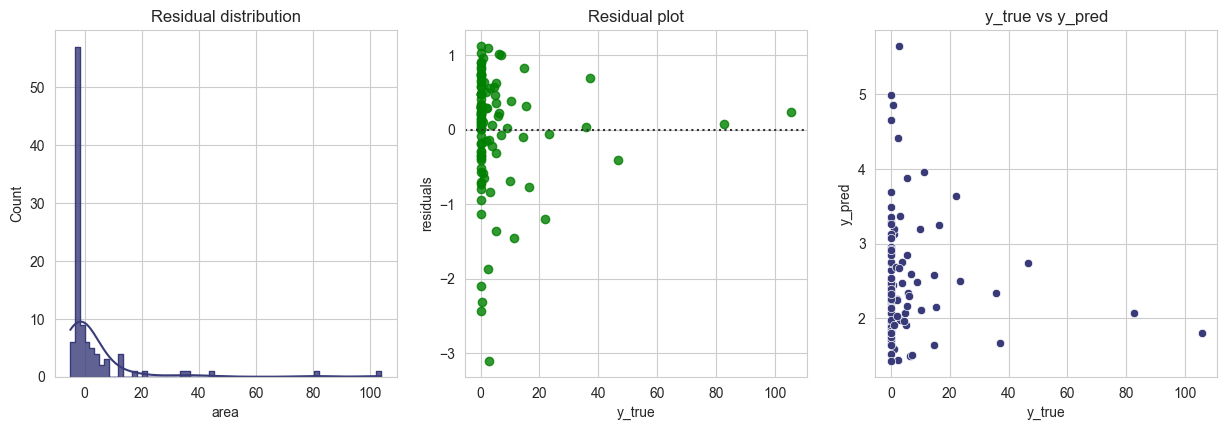

In [211]:
analyze_residuals(y_kbest_test, y_kbest_pred_test)

# Lasso Regularization

## Splitting

In [212]:
x_train, x_test, y_train, y_lasso_test = train_test_split(df.loc[:, [i != 'area' for i in df.columns.to_list()]], df.loc[:, ['area']], test_size=0.2, random_state=113131313)

## Preprocesing

In [213]:
column_transformer = TransformerList([FunctionTransformer(np.log1p, np.expm1), MinMaxScaler()])
y_lasso_train_changed = column_transformer.fit_transform(y_train)

In [214]:
categorical_mapping = gen_features(
    columns=[['month'], ['rain'], ['day']],
    classes=[TargetEncoder]
)
numerical_mapping = gen_features(
    columns=[[i] for i in ['DMC', 'DC', 'ISI', 'temp','wind']],
    classes=[StandardScaler]
)

In [215]:
mapper = DataFrameMapper(
    categorical_mapping + numerical_mapping + [(['FFMC'], StandartLog()), (['RH'], [FunctionTransformer(np.log1p, np.expm1), StandardScaler()])],
    default=None,
    df_out= True
)

In [216]:
x_lasso_train_changed, x_lasso_test_changed = mapper.fit_transform(x_train, y_lasso_train_changed), mapper.transform(x_test)

In [217]:
pd.DataFrame(y_lasso_train_changed).describe()

,0
count,410.000000
mean,0.168437
std,0.205686
min,0.000000
25%,0.000000
50%,0.082423
75%,0.302641
max,1.000000


# Lasso model

In [218]:
lasso_model = LassoCV(n_alphas=5, cv=10, max_iter=20000)
lasso_model.fit(x_lasso_train_changed, y_lasso_train_changed)

LassoCV(cv=10, max_iter=20000, n_alphas=5)

In [219]:
lasso_model.alpha_

0.03768143719834887

## Coeficients

In [220]:
coef_lasso = pd.DataFrame({
    'Feature': [f'{i}' for i in df_nozero.columns[:-1] ] + ['θ0'],
    'Coefficient': lasso_model.coef_.tolist() + [lasso_model.intercept_]
})
coef_lasso

,Feature,Coefficient
0,X,-0.000000
1,Y,-0.000000
2,month,-0.000000
3,day,0.000000
4,FFMC,0.000000
5,DMC,0.000000
6,DC,0.000000
7,ISI,0.000000
8,temp,-0.000000
9,RH,-0.000000


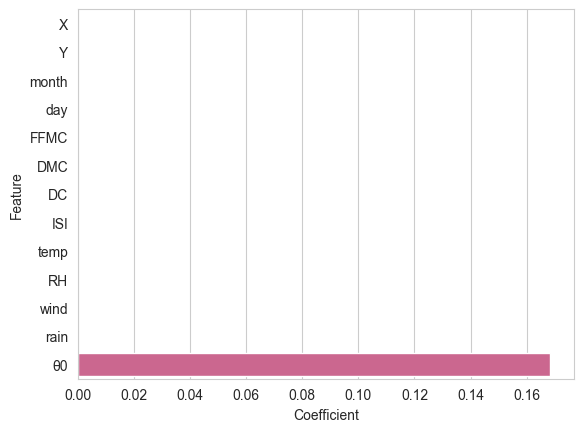

In [221]:
sns.barplot(x = abs(coef_lasso['Coefficient']), y = coef_lasso['Feature'], orient='h', palette='hls')
plt.show()

In [222]:
info_lasso, y_lasso_pred_test = report(x_lasso_train_changed, x_lasso_test_changed, y_train, y_lasso_test, lasso_model, column_transformer)
info_lasso

,Train set,Test set
MSE,5181.745401,230.180643
RMSE,71.984341,15.171705
MAE,14.863017,5.894098
R^2,-0.031221,-0.045012
Adjusted R^2,-0.062392,-0.076599


## Residual Analysis

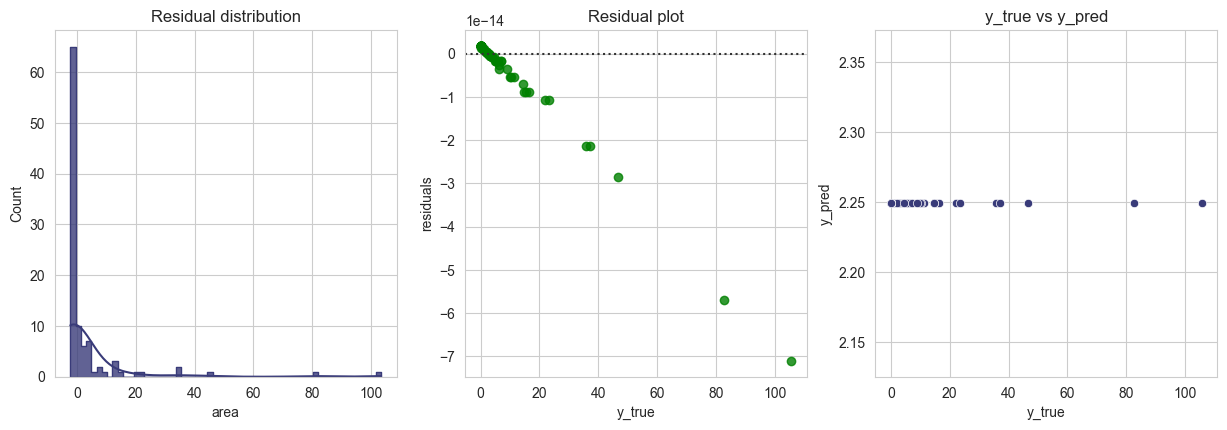

In [223]:
analyze_residuals(y_lasso_test, y_lasso_pred_test)

# Ridge

In [224]:
ridge_model = RidgeCV( alphas=[uniform.rvs() for i in range(5)] )
ridge_model.fit(x_lasso_train_changed, y_lasso_train_changed)

RidgeCV(alphas=[0.9161238104996392, 0.3110257784234435, 0.9069304810206612,
                0.16003526098127296, 0.5590980327509166])

In [225]:
info_ridge, y_ridge_pred_test = report(x_lasso_train_changed, x_lasso_test_changed, y_train, y_lasso_test, ridge_model, column_transformer)
info_ridge

,Train set,Test set
MSE,5157.536802,230.634076
RMSE,71.815993,15.186641
MAE,14.780348,6.077235
R^2,-0.026404,-0.047071
Adjusted R^2,-0.057428,-0.078720


## Coeficients

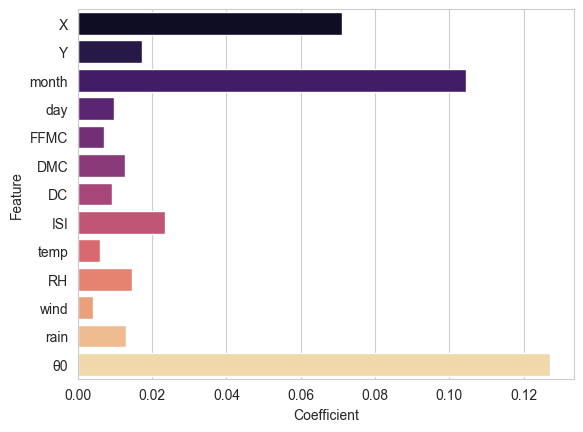

In [226]:
coef_lasso = pd.DataFrame({
    'Feature': [f'{i}' for i in df_nozero.columns[:-1] ] + ['θ0'],
    'Coefficient': ridge_model.coef_.tolist()[0] + [ridge_model.intercept_[0]]
})
sns.barplot(x = abs(coef_lasso['Coefficient']), y = coef_lasso['Feature'], orient='h', palette='magma')
plt.show()

## Residual Analysis

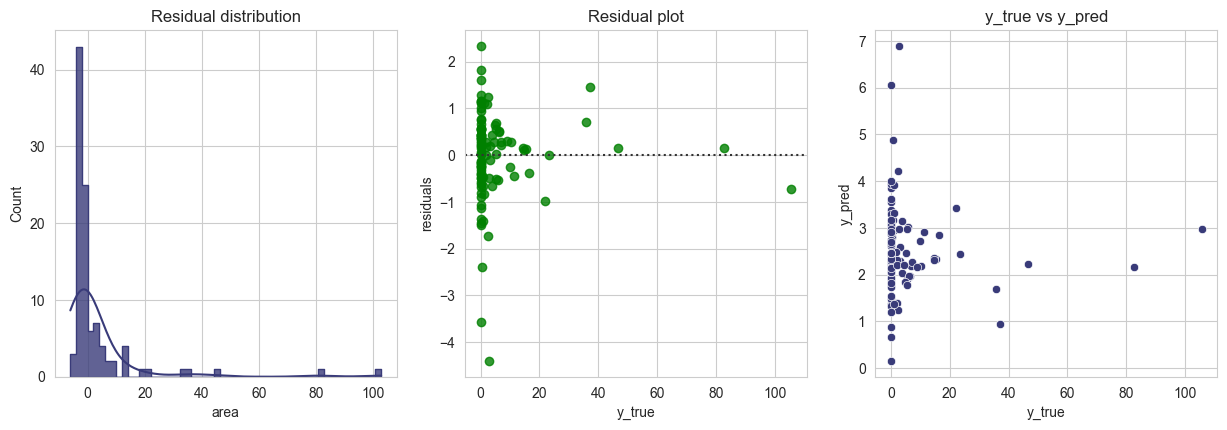

In [227]:
analyze_residuals(y_lasso_test, y_ridge_pred_test)


# Summary

In [228]:
pd.DataFrame([regression_report(y_st_test, y_st_pred_test, x_st_test_changed), 
              regression_report(y_sec_test, y_sec_pred_test, x_sec_test_changed),
              regression_report(y_man_test, y_man_pred_test, x_man_test_changed),
              regression_report(y_kbest_test, y_kbest_pred_test, x_kbest_test_changed),
              regression_report(y_lasso_test, y_lasso_pred_test, x_lasso_test_changed), 
              regression_report(y_lasso_test, y_ridge_pred_test, x_lasso_test_changed)], index = ['Standart LR', 'Reduced Zero LR', 'Manual Selected 3', 'Kbest Selected 3', 'Lasso Regularization', 'Ridge Regularization']).T

,Standart LR,Reduced Zero LR,Manual Selected 3,Kbest Selected 3,Lasso Regularization,Ridge Regularization
MSE,230.694847,275.766829,258.661506,231.235257,230.180643,230.634076
RMSE,15.188642,16.606229,16.082957,15.206422,15.171705,15.186641
MAE,6.098014,9.665412,8.815164,6.043447,5.894098,6.077235
R^2,-0.047347,-0.109354,-0.040543,-0.049800,-0.045012,-0.047071
Adjusted R^2,-0.186993,-0.442161,-0.104250,-0.189773,-0.184347,-0.186680
